[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andrescastro-itm/Conv1D_ecological//blob/main/AcousticIndices_Bloques_TEST.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pickle
from datetime import datetime
from pathlib import Path

from tqdm import tqdm

from dateutil import parser

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

plt.rcParams.update({'font.size': 16})
plt.rc('font', family='serif',size=16)

In [2]:
#When using on colab
!git clone https://github.com/andrescastro-itm/Conv1D_ecological

Cloning into 'Conv1D_ecological'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 76 (delta 9), reused 0 (delta 0), pack-reused 58
Unpacking objects: 100% (76/76), done.


In [3]:
cd 'Conv1D_ecological'

/content/Conv1D_ecological


In [4]:
if not os.path.exists('./Results/'):
    os.makedirs('./Results/')

In [5]:
PATH_FILES = 'data/AcousticIndices/'

Datos = ['2017/3785/20170510',
         '2017/3785/20170123',
         '2016/3786/20161221',
         '2016/3786/20160214',
         '2017/3786/20170123',
         '2016/3787/20161221',
         '2016/3787/20160407',
         '2015/3788/20151212',
         '2015/5067/20151212',
         '2016/5067/20160214',
         '2016/5069/20160224',
         '2016/5069/20160407',
         '2015/5070/20151212',
         '2016/5070/20160214',
         '2016/5071/20160305',
         '2017/5071/20170123',
         '2017/5071/20170213',
         '2016/5071/20161221',
         '2016/5071/20160224',
         '2016/5071/20160214',
         '2017/5071/20170510',
         '2016/5071/20160407',
         '2015/5072/20151212',
         '2016/5072/20160214',
         '2017/302143/20170123',
         '2016/302143/20161221',
         '2017/302143/20170510',
         '2017/302151/20170202',
         '2016/302151/20161221',
         '2017/302151/20170510',
         '2017/302298/20170123',
         '2017/302298/20170212',
         '2015/JSC5069/20151212',
         '2015/LAS40-5069/20151212',
         ]

Clases = ['Media',
          'Media',
          'Baja',
          'Baja',
          'Media',
          'Baja',
          'Media',
          'Baja',
          'Alta',
          'Media',
          'Alta',
          'Media',
          'Baja',
          'Media',
          'Alta',
          'Alta',
          'Alta',
          'Alta',
          'Baja',
          'Baja',
          'Media',
          'Media',
          'Media',
          'Media',
          'Alta',
          'Baja',
          'Media',
          'Baja',
          'Media',
          'Media',
          'Baja',
          'Baja',
          'Baja',
          'Media',
          ]

transANumero = {'Baja': 0, 'Media': 1, 'Alta': 2}
etiquetas = [transANumero[i] for i in Clases]

In [6]:
UsadNestor = [1,2,4,5,7,8,9,10,12,13,14,15,17,18,19,22,23,24,25,27,28,30,32,33]
DatosN = [Datos[i] for i in UsadNestor]
etiquetasN = [etiquetas[i] for i in UsadNestor]

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [8]:
class MyDatasetTRAIN(Dataset):

    def __init__(self, ListaArchivos, etiquetas, numbloq = 24):
        self.numbloq = numbloq
        self.lista = ListaArchivos
        self.n = len(ListaArchivos)*self.numbloq #ya no es necesario el 24, ya no es bloque por hora fija sino muchos bloques que incluyen todas las horas
        self.y = etiquetas
    
    def __getitem__(self, index):
        archivo = index//self.numbloq #qué archivo usar
        
        ruta = self.lista[archivo]
        name = '_'.join(ruta.split('/'))
        
        df = pd.read_csv(f"{PATH_FILES}indices_{name}.csv", index_col='Date')
        df.index = pd.Series(df.index.map(parser.parse))
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df = df.fillna(df.mean())

        L = np.arange(df.shape[0])

        HM = df.index.strftime('%H:%M')
        
        Data1 = torch.empty((0,60)) 
        for bloque in range(24):
            ini = f"{bloque:02}:00"
            final = f"{bloque+1:02}:00"
            Sel = np.logical_and(HM >= ini, HM < final)
            
            nd = sum(Sel)
            ndata = int(0.8*nd)
            row = np.random.permutation(ndata)[0]
            
            indices_datos = L[Sel]
            fila1 = torch.tensor(df.iloc[indices_datos[row],1:].values.astype('float'))
            Data1 = torch.cat((Data1,fila1.view(1,-1)), axis=0)

        
        label = self.y[archivo]
        return Data1, label, bloque

    def __len__(self):
        return self.n

In [9]:
class MyDatasetTEST(Dataset):

    def __init__(self, ListaArchivos, etiquetas, numbloq = 24):
        self.numbloq = numbloq
        self.lista = ListaArchivos
        self.n = len(ListaArchivos)*self.numbloq #ya no es necesario el 24, ya no es bloque por hora fija sino muchos bloques que incluyen todas las horas
        self.y = etiquetas
    
    def __getitem__(self, index):
        archivo = index//self.numbloq #qué archivo usar
        
        ruta = self.lista[archivo]
        name = '_'.join(ruta.split('/'))
        
        df = pd.read_csv(f"{PATH_FILES}indices_{name}.csv", index_col='Date')
        df.index = pd.Series(df.index.map(parser.parse))
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df = df.fillna(df.mean())

        L = np.arange(df.shape[0])

        HM = df.index.strftime('%H:%M')
        
        Data1 = torch.empty((0,60)) 
        for bloque in range(24):
            ini = f"{bloque:02}:00"
            final = f"{bloque+1:02}:00"
            Sel = np.logical_and(HM >= ini, HM < final)
            nd = sum(Sel)
            ndata = int(0.8*nd)
            row = np.random.randint(ndata,nd)
            
            indices_datos = L[Sel]
            nvalid = df.iloc[row,1]
            fila1 = torch.tensor(df.iloc[indices_datos[row],1:].values.astype('float'))
            Data1 = torch.cat((Data1,fila1.view(1,-1)), axis=0)

        
        label = self.y[archivo]
        return Data1, label, bloque

    def __len__(self):
        return self.n

In [10]:
BATCH_SIZE = 16#16
NUM_TENSORES_TR = 100#200
NUM_TENSORES_TE = 30#20

train_dataset = MyDatasetTRAIN(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, numbloq=NUM_TENSORES_TR)

trainsize = int(0.8*len(train_dataset))
testsize = len(train_dataset) - trainsize

tr_set, val_set = torch.utils.data.random_split(train_dataset, [trainsize, testsize])

test_set = MyDatasetTEST(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, numbloq=NUM_TENSORES_TE)

print(len(tr_set), len(val_set), len(test_set), len(train_dataset))

tr_loader = DataLoader(dataset=tr_set,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

test_loader = DataLoader(dataset=test_set,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

1920 480 720 2400


In [11]:
def AE_MaxMin(A, maxi, mini):
    return (A-mini)/(maxi-mini+1e-6)

In [12]:
def AE_loader2flatten(loader, ndim = 60):
    X = torch.empty(0,ndim*24)
    y = torch.empty(0)
    for A, et, _ in loader:
        AA = A.transpose(1, 2).flatten().view(A.shape[0],-1)
        X = torch.concat((X,AA))

        y = torch.concat((y,et), dim=0)
    return X.numpy(), y.numpy()

 ## RF

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [14]:
try:
    with open('AcousticIndpickles/normDataMaxMin.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
        Tmax = unserialized_data['max']
        Tmin = unserialized_data['mini']
        
    with open('AcousticIndpickles/AcousticDataFlatten.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
        X_train = unserialized_data['X_train']
        X_val = unserialized_data['X_val']
        X_test = unserialized_data['X_test']
        y_train = unserialized_data['y_train']
        y_val = unserialized_data['y_val']
        y_test = unserialized_data['y_test']
        print('Data loaded!')
except:
    print('Normalizing data')
    X_train_, y_train = AE_loader2flatten(tr_loader)
    X_val_, y_val = AE_loader2flatten(val_loader)
    X_test_, y_test = AE_loader2flatten(test_loader)

    
    X_train_[np.isnan(X_train_)] = 0 #Los valores de nan en X hacerlos 0, imputar desde pandas?
    X_test_[np.isnan(X_test_)] = 0
    X_val_[np.isnan(X_val_)] = 0
    
    Tmax = np.max(X_train_,0)
    Tmin = np.min(X_train_,0)
    X_train = AE_MaxMin(X_train_,Tmax, Tmin)
    X_val = AE_MaxMin(X_val_,Tmax, Tmin)
    X_test = AE_MaxMin(X_test_,Tmax, Tmin)
    
    normData = {'max': Tmax, 'mini':Tmin}
    Data = {'X_train': X_train, 'y_train':y_train, 'X_val': X_val, 'y_val':y_val, 'X_test': X_test, 'y_test':y_test}
    # Store data (serialize)
    with open('AcousticIndpickles/normDataMaxMin.pickle', 'wb') as handle:
        pickle.dump(normData, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('AcousticIndpickles/AcousticDataFlatten.pickle', 'wb') as handle:
        pickle.dump(Data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Data loaded!


In [15]:
clf = RandomForestClassifier(max_depth=20, random_state=42)
clf.fit(X_train.astype(np.float32), y_train.astype(np.float32))
predictions = clf.predict(X_val)

In [16]:
mat_confusion = confusion_matrix(
                    y_true    = y_val,
                    y_pred    = predictions
                )

accuracy = accuracy_score(
            y_true    = y_val,
            y_pred    = predictions,
            normalize = True
           )

print("Confusion Matrix")
print("-------------------")
print(mat_confusion)
print("")
print(f"Validation accuracy is: {100 * accuracy} %")

Confusion Matrix
-------------------
[[190   0   0]
 [  0 161   0]
 [  0   1 128]]

Validation accuracy is: 99.79166666666667 %


In [17]:
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [18]:
def AE_testClass(model, x_test, y_test):
    predictions = model.predict(x_test)
    pred_per_block = stats.mode(predictions.T.reshape(-1,24), axis=1)[0]
    y_test = y_test[::24]
    
    return y_test, pred_per_block

In [19]:
# y_testBlock, predictions = AE_testClass(clf,X_test, y_test)
predictions = clf.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predictions
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print("Confusion Matrix")
print("-------------------")
print(mat_confusion)
print("")
print(f"Test accuracy is: {100 * accuracy} %")

Confusion Matrix
-------------------
[[277  22   1]
 [ 31 207   2]
 [  0  17 163]]

Test accuracy is: 89.86111111111111 %


0.8986111111111111


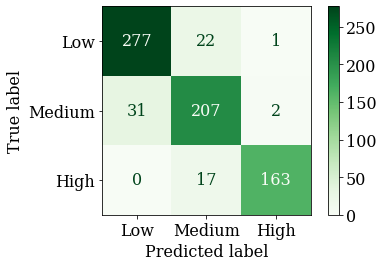

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Greens', display_labels=['Low', 'Medium','High'])
plt.tight_layout()
plt.savefig('./Results/AI_RF_CF.pdf', transparent=True, dpi=300)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print(accuracy)

In [21]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       300
         1.0       0.84      0.86      0.85       240
         2.0       0.98      0.91      0.94       180

    accuracy                           0.90       720
   macro avg       0.91      0.90      0.90       720
weighted avg       0.90      0.90      0.90       720



## MLP

In [22]:
from torch.utils.data import DataLoader, TensorDataset

#######################
### SETTINGS        ###
#######################
X_train
RANDOM_SEED = 42
BATCH_SIZE_MLP = 64
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

##################################
### FROM DATASET TO DATALOADER ###
##################################

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

Traindataset = TensorDataset(X_train, y_train)
Testdataset = TensorDataset(X_test, y_test)
Valdataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(dataset=Traindataset, 
                          batch_size=BATCH_SIZE_MLP, 
                          shuffle=True)

val_loader2 = DataLoader(dataset=Valdataset, 
                         batch_size=BATCH_SIZE_MLP, 
                         shuffle=False)

test_loader2 = DataLoader(dataset=Testdataset, 
                         batch_size=BATCH_SIZE_MLP, 
                         shuffle=False)

# Checking the dataset
for batch, etiquetas  in test_loader2:  
    print('Image batch dimensions:', batch.shape)
    print('Image label dimensions:', etiquetas.shape)
    break

cuda:0
Image batch dimensions: torch.Size([64, 1440])
Image label dimensions: torch.Size([64])


In [23]:
import time
from torch import nn

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        logits = self.linear_out(out)
        probas = torch.softmax(logits, dim=1)
        return logits

    
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=60*24,
            num_hidden=150,
            num_classes=3)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

#################################
### Training
#################################

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 1440).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net(features).to(DEVICE)
            loss = F.cross_entropy(logits.to(DEVICE), targets.squeeze().type(torch.LongTensor).to(DEVICE))
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
loss_function = nn.CrossEntropyLoss()
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features.float()).to(DEVICE)
        
        cost = loss_function(logits.to(DEVICE), targets.squeeze().type(torch.LongTensor).to(DEVICE))
        optimizer.zero_grad()
        
        cost.backward()
       
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost.item()))
        
    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/030 | Cost: 1.1217
Epoch: 001/050 Train Cost: 0.5843
Time elapsed: 0.04 min
Epoch: 002/050 | Batch 000/030 | Cost: 0.6022
Epoch: 002/050 Train Cost: 0.3163
Time elapsed: 0.04 min
Epoch: 003/050 | Batch 000/030 | Cost: 0.3336
Epoch: 003/050 Train Cost: 0.1497
Time elapsed: 0.04 min
Epoch: 004/050 | Batch 000/030 | Cost: 0.1371
Epoch: 004/050 Train Cost: 0.0724
Time elapsed: 0.04 min
Epoch: 005/050 | Batch 000/030 | Cost: 0.0541
Epoch: 005/050 Train Cost: 0.0529
Time elapsed: 0.05 min
Epoch: 006/050 | Batch 000/030 | Cost: 0.0343
Epoch: 006/050 Train Cost: 0.0338
Time elapsed: 0.05 min
Epoch: 007/050 | Batch 000/030 | Cost: 0.0329
Epoch: 007/050 Train Cost: 0.0413
Time elapsed: 0.05 min
Epoch: 008/050 | Batch 000/030 | Cost: 0.0250
Epoch: 008/050 Train Cost: 0.0778
Time elapsed: 0.05 min
Epoch: 009/050 | Batch 000/030 | Cost: 0.0877
Epoch: 009/050 Train Cost: 0.0367
Time elapsed: 0.05 min
Epoch: 010/050 | Batch 000/030 | Cost: 0.0247
Epoch: 010/050 Train Cost: 

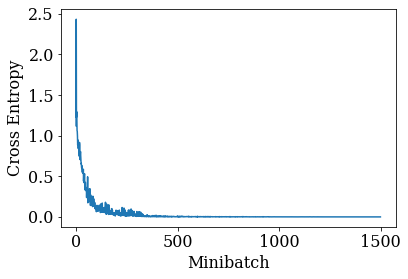

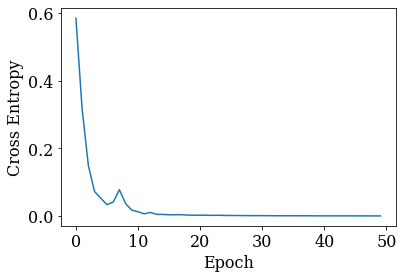

In [24]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [25]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets.squeeze()).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Val Accuracy: %.2f' % compute_accuracy(model, val_loader2))

Training Accuracy: 100.00
Val Accuracy: 99.38


In [26]:
def compute_predictions(net, data_loader):
    predictions = []
    labels = []
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            predictions = predictions + predicted_labels.detach().tolist()
            labels = labels + targets.view(-1).detach().tolist()
        return np.array(labels), np.array(predictions)

In [27]:
labels,predictions = compute_predictions(model, test_loader2)


In [28]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       300
         1.0       0.77      0.65      0.71       240
         2.0       0.86      0.97      0.91       180

    accuracy                           0.81       720
   macro avg       0.81      0.82      0.81       720
weighted avg       0.81      0.81      0.81       720



0.8097222222222222


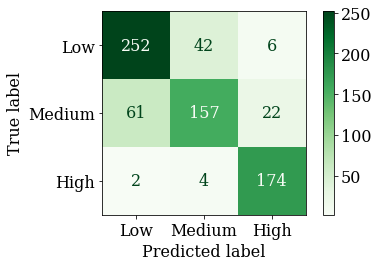

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap='Greens', display_labels=['Low', 'Medium','High'])
plt.tight_layout()
plt.savefig('./Results/AI_MLP_CF.pdf', transparent=True, dpi=300)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predictions,
            normalize = True
           )

print(accuracy)

## Conv1D

In [30]:
class TransAudio(torch.nn.Module):

    def __init__(self, d_model, num_clas):
        super(TransAudio, self).__init__()
        
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.lineal1 = torch.nn.Linear(60*64,512)
        self.relu = torch.nn.ReLU()
        self.lineal2 = torch.nn.Linear(512,128)
        self.lineal3 = torch.nn.Linear(128,num_clas)
        self.softmax = torch.nn.Softmax()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):#, idx):

        out1 = self.conv1d(x)
        out1 = out1.view(out1.size(0),-1)
        out1 = self.lineal1(out1).squeeze()
        out1 = self.relu(out1)
        out1 = self.dropout(out1)
        out1 = self.lineal2(out1).squeeze()
        out1 = self.relu(out1)
        out1 = self.dropout(out1)
        out1 = self.lineal3(out1).squeeze()

        return out1.unsqueeze(dim=0)

In [31]:
try:
    model = TransAudio(60,3)
    model.load_state_dict(torch.load('models/AcousticConv1Dmodel_stDict.pt'))
    model.to(DEVICE)
    model.eval()
    print('Model loaded!')
except:

    NUM_EPOCHS = 100
    model = TransAudio(60,3)
    model = model.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    minibatch_cost = []

    for epoch in range(NUM_EPOCHS):
        for batch_idx, (A, et) in enumerate(train_loader):
            output = model(A.unsqueeze(1).to(DEVICE))
            et = et.to(DEVICE)

            loss = criterion(F.softmax(output[0,...], dim=-1),et.long())
            optimizer.zero_grad()

            loss.backward()
            minibatch_cost.append(loss.item())
            optimizer.step()

            if not batch_idx % 2:
                print (f'Epoch: {epoch+1:03}/{NUM_EPOCHS:03} | Batch {batch_idx:03}/{len(tr_loader):03} | Cost: {loss.item():.4}')
                
    torch.save(model.state_dict(),'models/AcousticConv1Dmodel_stDict.pt')

Model loaded!


In [32]:
resul = 0
model.eval()

predictions = []
labels = []

for batch_idx, (A, et) in enumerate(val_loader2):
    et = et.to(DEVICE)
    output = model(A.unsqueeze(1).to(DEVICE))

    out1 = F.softmax(output, dim=-1)

    out1 = out1.argmax(dim=-1)
    predictions = predictions + out1.view(-1).detach().tolist()
    labels = labels + et.view(-1).detach().tolist()

    resul = resul + torch.sum(out1==et)# + torch.sum(out2==et)

print(resul/(BATCH_SIZE*len(val_loader)))

tensor(0.9958, device='cuda:0')


In [33]:
resul = 0
model.eval()

predictions = []
labels = []

for batch_idx, (A, et) in enumerate(test_loader2):
    et = et.to(DEVICE)
    output = model(A.unsqueeze(1).to(DEVICE))

    out1 = F.softmax(output, dim=-1)

    out1 = out1.argmax(dim=-1)
    predictions = predictions + out1.view(-1).detach().tolist()
    labels = labels + et.view(-1).detach().tolist()

    resul = resul + torch.sum(out1==et)# + torch.sum(out2==et)

print(resul/(BATCH_SIZE*len(test_loader)))

tensor(0.9111, device='cuda:0')


In [34]:
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       300
         1.0       0.93      0.83      0.88       240
         2.0       0.94      0.90      0.92       180

    accuracy                           0.91       720
   macro avg       0.92      0.90      0.91       720
weighted avg       0.91      0.91      0.91       720



0.9111111111111111


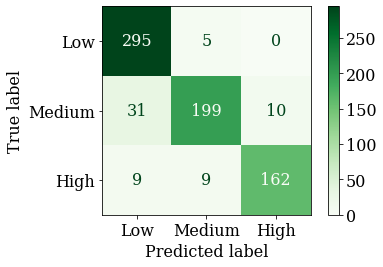

In [35]:
ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap='Greens', display_labels=['Low', 'Medium','High'])
plt.tight_layout()
plt.savefig('./Results/AI_CONV1D_CF.pdf', transparent=True, dpi=300)

accuracy = accuracy_score(
            y_true    = labels,
            y_pred    = predictions,
            normalize = True
           )

print(accuracy)

<hr>